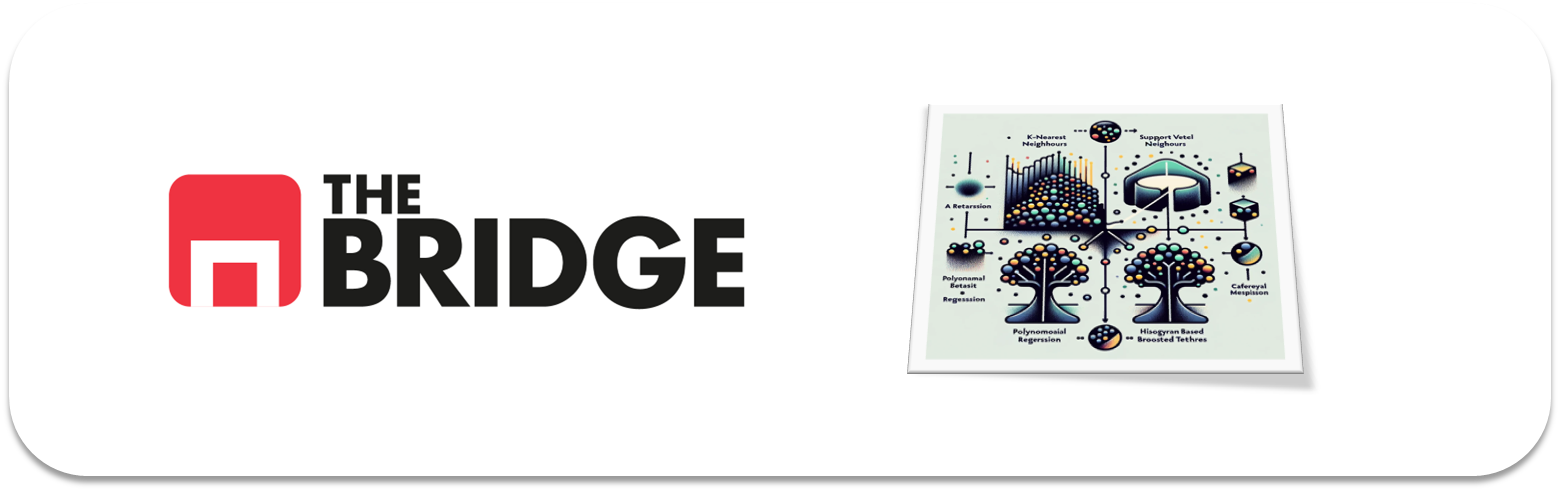

## PRACTICA OBLIGATORIA: **Repaso Aprendizaje Supervisado**

* La práctica obligatoria de esta unidad consiste en resolver sobre un mismo dataset un problema de clasificación y un problema de regresión. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [175]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor, XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE


### #1 Explicación del dataset y carga de datos

Vamos a trabajar con el dataset "Wine Quality", que es un dataset en el que se recogen diversas características fisicoquímicas de las variades tinta y blanca del "Vinho verde" portugués. Las variables del dataset se describen a continuación


1. **Acidez fija**: La mayoría de los ácidos involucrados con el vino son fijos o no volátiles (no se evaporan fácilmente).
2. **Acidez volátil**: La cantidad de ácido acético en el vino, que en niveles demasiado altos puede llevar a un sabor desagradable a vinagre.
3. **Ácido cítrico**: Encontrado en pequeñas cantidades, el ácido cítrico puede añadir 'frescura' y sabor a los vinos.
4. **Azúcar residual**: Es la cantidad de azúcar restante después de que se detiene la fermentación, es raro encontrar vinos con menos de 1 gramo/litro y vinos con más de 45 gramos/litro se consideran dulces.
5. **Cloruros**: La cantidad de sal en el vino.
6. **Dióxido de azufre libre**: La porción libre de SO2 existe en equilibrio entre el SO2 molecular (como un gas disuelto) y el ion bisulfito; previene el crecimiento microbiano y la oxidación del vino.
7. **Dióxido de azufre total**: Es la cantidad de formas libres y ligadas de S02; en bajas concentraciones, el SO2 es en su mayoría indetectable en el vino, pero en concentraciones libres de más de 50 ppm, el SO2 se hace evidente en la nariz y el sabor del vino.
8. **Densidad**: La densidad del vino es cercana a la del agua dependiendo del porcentaje de alcohol y contenido de azúcar.
9. **pH**: Describe qué tan ácido o básico es un vino en una escala de 0 (muy ácido) a 14 (muy básico); la mayoría de los vinos están entre 3-4 en la escala de pH.
10. **Sulfatos**: Un aditivo del vino que puede contribuir a los niveles de dióxido de azufre (SO2), que actúa como un antimicrobiano y antioxidante.
11. **Alcohol**: El porcentaje de contenido de alcohol del vino.
12. **Calidad**: Una variable de salida (basada en datos sensoriales, puntuación entre 0 y 10).
13. **Class**: Si es blanco o tinto.



Carga el dataset "wines_dataset.csv", muestra sus primeras filas, su información general y define dos variables target una para clasificación que permita predecir la calidad del vino según el resto de propiedas y otra variable target para regresión que permita predecir el grado alcohólico del vino a partir del resto de propiedades. 

El **objetivo de negocio en el primer problema** será anticipar la posible clasificación de sus vinos por los catadores profesionales y a partir de ahí poder planificar la producción, distribución y precio a poner a cada vino. En este sentido, el "cliente" nos dice que le gustaría poder clasificar correctamente lo mejor posible en media  (que interpretamos como el mejor recall medio posible).

El **objetivo de negocio en el segundo problema** (bastante artificial) es poder hacer simulaciones de posibles vinos futuros para saber cómo conseguir variedades más o menos alcohólicas para atender mercados diferentes. En este sentido, les interesa equivocarse lo menos posible porcentualmente sobre el grado alochólico real.

Muestra la distribución de ambos targets y haz un pequeño assesment previo de cada problema. NOTA: El dataset está limpio y sin valores faltantes.

In [13]:
df = pd.read_csv("./data/wines_dataset.csv", sep="|")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,8.5,0.21,0.26,9.25,0.034,73.0,142.0,0.99450,3.05,0.37,11.4,6,white
1,8.3,0.16,0.37,7.90,0.025,38.0,107.0,0.99306,2.93,0.37,11.9,6,white
2,6.8,0.18,0.38,1.40,0.038,35.0,111.0,0.99180,3.32,0.59,11.2,7,white
3,6.1,0.26,0.25,2.90,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3,white
4,7.5,0.63,0.27,2.00,0.083,17.0,91.0,0.99616,3.26,0.58,9.8,6,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,7.7,0.39,0.34,10.00,0.056,35.0,178.0,0.99740,3.26,0.60,10.2,5,white
6493,8.2,0.73,0.21,1.70,0.074,5.0,13.0,0.99680,3.20,0.52,9.5,5,red
6494,7.4,0.31,0.48,14.20,0.042,62.0,204.0,0.99830,3.06,0.59,9.4,5,white
6495,8.3,0.65,0.10,2.90,0.089,17.0,40.0,0.99803,3.29,0.55,9.5,5,red


array([[<Axes: title={'center': 'quality'}>,
        <Axes: title={'center': 'alcohol'}>]], dtype=object)

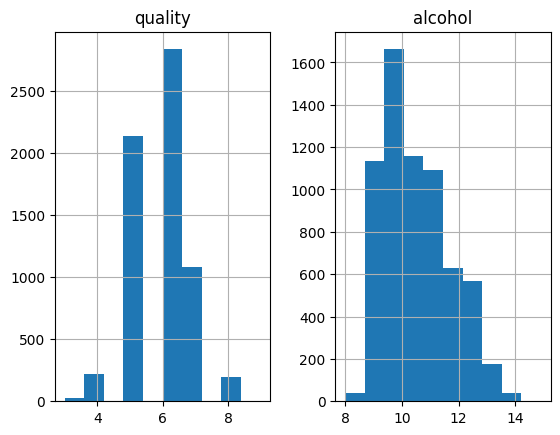

In [14]:
target_clas = "quality"
target_reg = "alcohol"

df[[target_clas, target_reg]].hist()

- quality =  bastante desbalanceadas
- alcohol = distribucion tirando a normal 

### #2 Modelado para clasificación

Crea un modelo que permita clasificar lo mejor posible los vinos en función de su calidad, o dicho de otro modo que prediga de la mejor manera posible la calidad de un vino a partir de sus propiedades químicas. ***Considéralo un problema de clasificación***, donde los valores de calidad son las clases a predecir. Puedes utilizar los modelos que creas conveniente, al menos tres, y utiliza un KNN como modelo baseline, prueba al menos con 2 valores de K. Intenta mejorar el "recall medio" con las técnicas que creas conveniente. Compara los modelos utilizando validación cruzada con o sin optimización previa de hiperparámetros (aunque en la sesión en vivo por limitación de tiempos sólo lo haremos con validación cruzada). El modelo elegido si tiene que tener un ejemplo de optimización de parámetros.

Evalúa el modelo, analiza los errores y propón algún mecanismo de mejora aunque sea sólo un esbozo.

**recall medio**

In [15]:
train_clas, test_clas = train_test_split(df, test_size=.2, random_state=42)

In [29]:
num_clas = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
cat_clas = ["class"]

#### eda

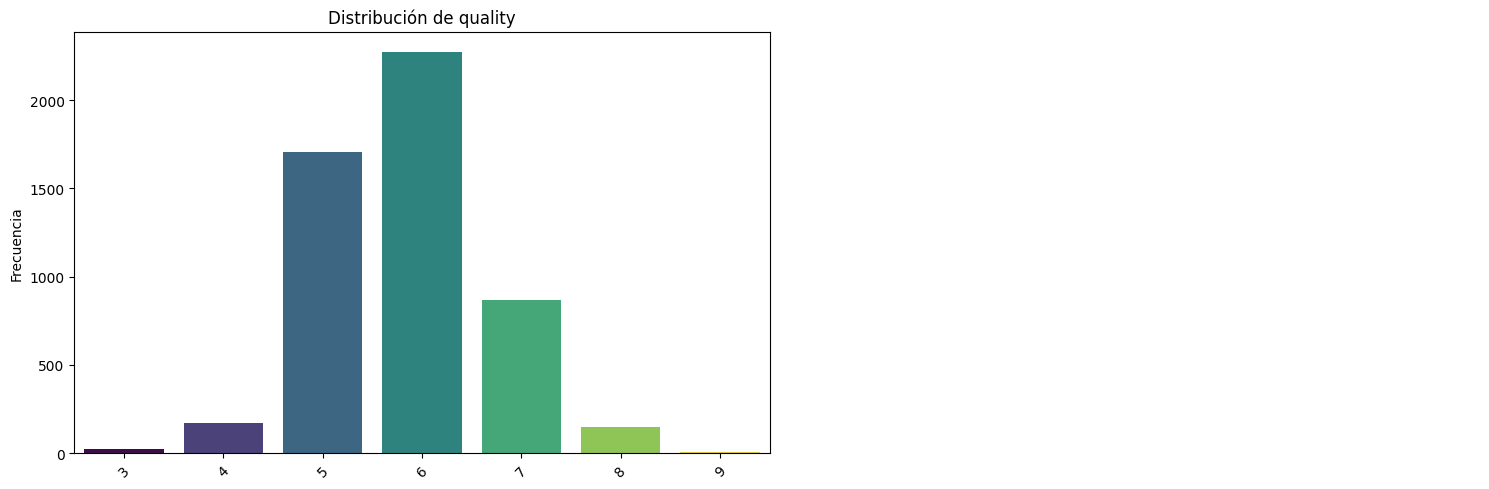

In [16]:
bt.pinta_distribucion_categoricas(train_clas, [target_clas])

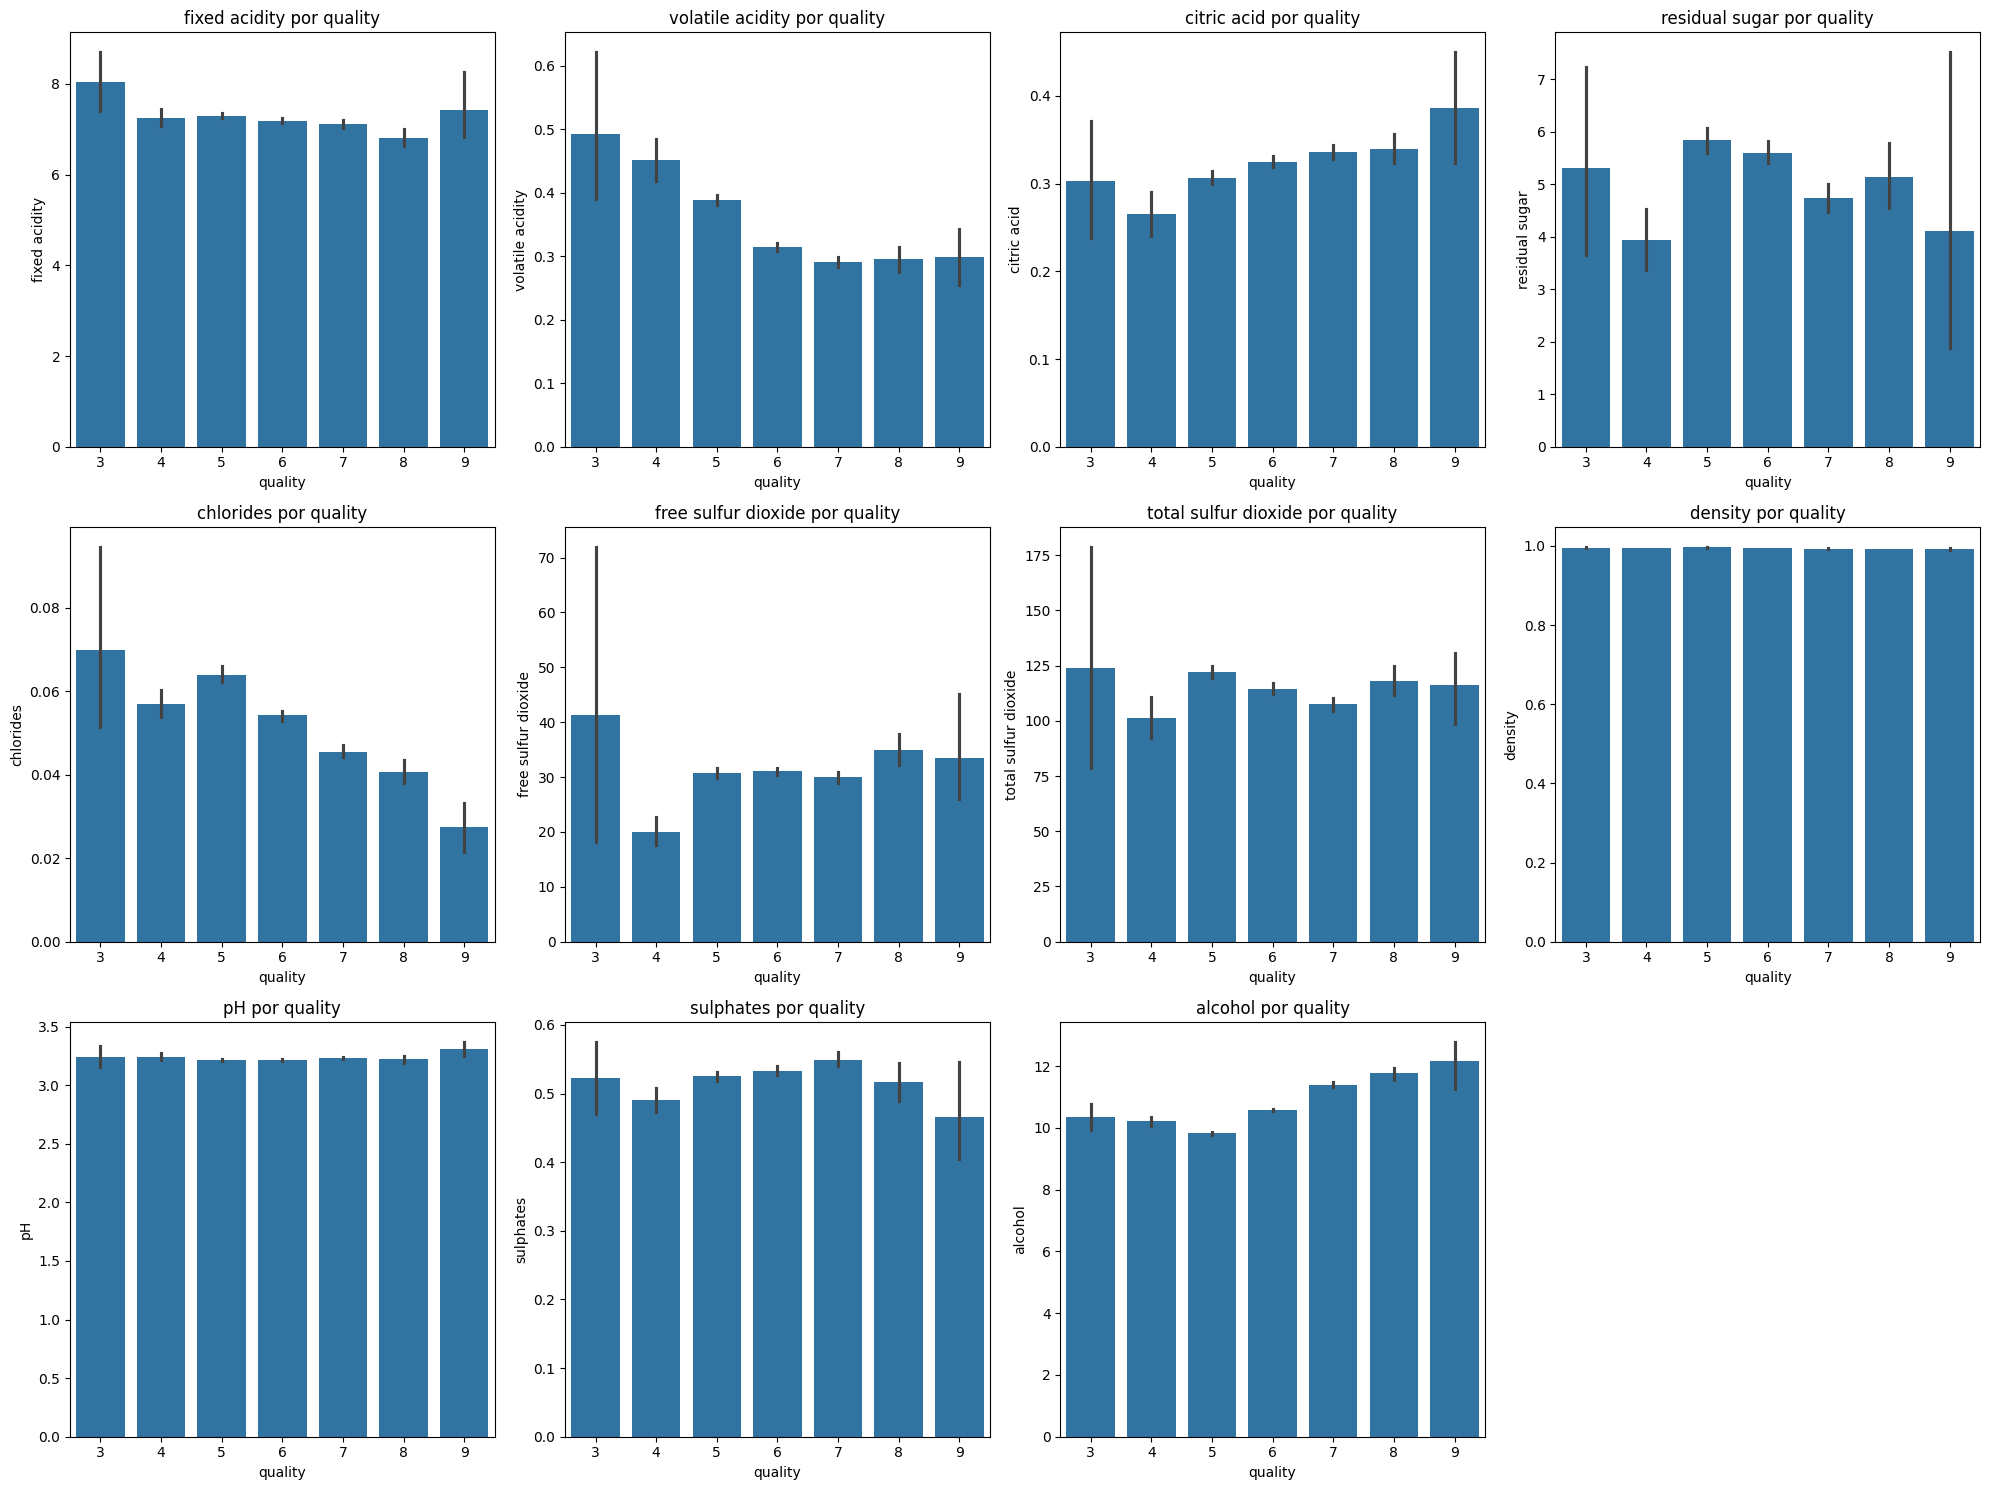

In [40]:
def grouped_barplots(data, categorical_column, numeric_columns):
    num_plots = len(numeric_columns)
    num_rows = int(np.ceil(num_plots / 4))
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows*5))
    axes = axes.flatten()
    for i, numeric_column in enumerate(numeric_columns):
        ax = axes[i]
        sns.barplot(x=categorical_column, y=numeric_column, data=data, ax=ax)
        ax.set_title(f'{numeric_column} por {categorical_column}')
        ax.set_xlabel(categorical_column)
        ax.set_ylabel(numeric_column)
    # Ocultar ejes sobrantes
    for j in range(num_plots, num_rows*4):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()


grouped_barplots(train_clas, target_clas, num_clas)



In [ ]:
num_clas.remove("pH")
num_clas.remove("density")

# no influyen nada en quality

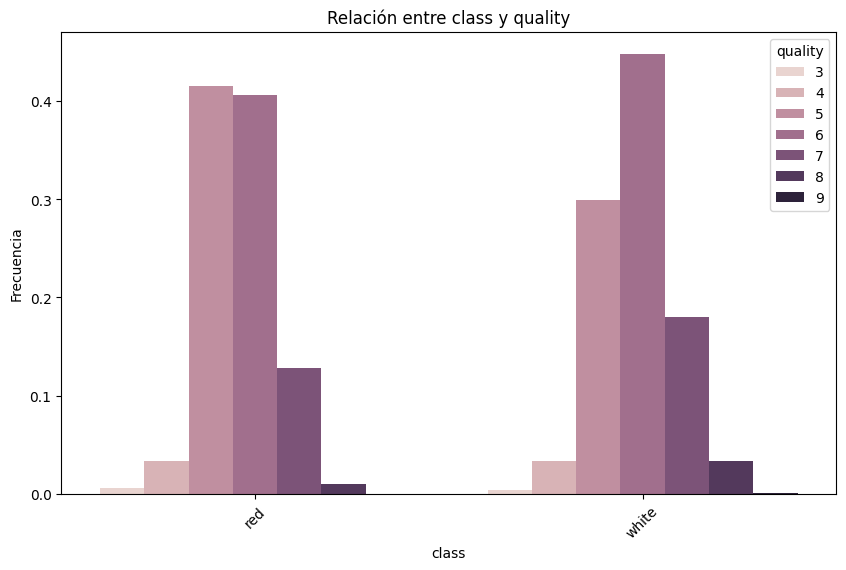

In [53]:
bt.plot_categorical_relationship_fin(train_clas, "class", "quality", relative_freq=True)

- una distribución bastante diferente

#### tratamiento

In [56]:
train_clas_backup = train_clas.copy()

In [57]:
# escalado de numericas
scaler = StandardScaler()
train_clas[num_clas] = scaler.fit_transform(train_clas[num_clas])

In [60]:
# categorica

train_clas[cat_clas] = train_clas[cat_clas].replace({"white": 0, "red": 1})

In [64]:
test_clas[num_clas] = scaler.transform(test_clas[num_clas])
test_clas[cat_clas] = test_clas[cat_clas].replace({"white": 0, "red": 1})

#### modelado

In [65]:
features = num_clas+cat_clas
X_train = train_clas[features]
X_test = test_clas[features]
y_train = train_clas[target_clas]
y_test = test_clas[target_clas]

##### knn

In [101]:
y_train.value_counts()

quality
6    2274
5    1706
7     869
4     173
8     146
3      24
9       5
Name: count, dtype: int64

In [103]:
for i in range(1,6):
    knn_clas = KNeighborsClassifier(n_neighbors=i)
    recall_medio = cross_val_score(knn_clas, X_train, y_train, cv=5, scoring="balanced_accuracy")
    print(i, recall_medio.mean())

1 0.3642847850136176
2 0.29308626463534043
3 0.2840154337590895
4 0.27281888573338436
5 0.2651084604645966


##### comparando modelos

In [73]:
knn_clas = KNeighborsClassifier()
rf_clas = RandomForestClassifier()
lgbm_clas = LGBMClassifier(verbose=-1)

clasificadores = [knn_clas, rf_clas, lgbm_clas]

In [79]:
mayor_recall = 0

for clas in clasificadores:
    recall_medio = cross_val_score(clas, X_train, y_train, cv=5, scoring="balanced_accuracy").mean()
    if recall_medio > mayor_recall:
        mayor_recall = recall_medio
        guanyador = clas
    print(clas, recall_medio)
print("\nGana", guanyador, recall_medio)


KNeighborsClassifier() 0.2651084604645966
RandomForestClassifier() 0.3348406947964897
LGBMClassifier(verbose=-1) 0.33808453749149436

Gana LGBMClassifier(verbose=-1) 0.33808453749149436


- bajisimo recall

##### smote

In [92]:
smote = SMOTE(random_state=42,
              k_neighbors=3)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
y_train_smote.value_counts()

quality
5    2274
6    2274
7    2274
3    2274
4    2274
8    2274
9    2274
Name: count, dtype: int64

In [93]:
knn_clas = KNeighborsClassifier()
rf_clas = RandomForestClassifier()
lgbm_clas = LGBMClassifier(verbose=-1)

clasificadores = [knn_clas, rf_clas, lgbm_clas]
mayor_recall = 0

for clas in clasificadores:
    recall_medio = cross_val_score(clas, X_train_smote, y_train_smote, cv=5, scoring="balanced_accuracy").mean()
    if recall_medio > mayor_recall:
        mayor_recall = recall_medio
        guanyador = clas
    print(clas, recall_medio)
print("\nGana", guanyador, recall_medio)


KNeighborsClassifier() 0.840507334075616
RandomForestClassifier() 0.9025101141778297
LGBMClassifier(verbose=-1) 0.873981562804722

Gana RandomForestClassifier() 0.873981562804722


In [94]:

grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200],
    'max_depth': [10,30,None],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_lgbm = GridSearchCV(lgbm_clas,
                         grid,
                         cv=5,
                         scoring="balanced_accuracy")

grid_lgbm.fit(X_train_smote, y_train_smote)



print(classification_report(y_true=y_train_smote, y_pred=grid_lgbm.best_estimator_.predict(X_train_smote)))

              precision    recall  f1-score   support

           3       1.00      1.00      1.00      2274
           4       1.00      1.00      1.00      2274
           5       1.00      1.00      1.00      2274
           6       1.00      1.00      1.00      2274
           7       1.00      1.00      1.00      2274
           8       1.00      1.00      1.00      2274
           9       1.00      1.00      1.00      2274

    accuracy                           1.00     15918
   macro avg       1.00      1.00      1.00     15918
weighted avg       1.00      1.00      1.00     15918



In [99]:
grid_lgbm.best_estimator_

LGBMClassifier(max_depth=30, n_estimators=200, num_leaves=70, verbose=-1)

In [96]:
# mean recall con smote
cross_val_score(grid_lgbm.best_estimator_, X_train_smote, y_train_smote, cv=5, scoring="balanced_accuracy")

array([0.86057857, 0.88006279, 0.91458516, 0.91858173, 0.93057559])

In [100]:
# mean recall sin smote
cross_val_score(grid_lgbm.best_estimator_, X_train, y_train, cv=5, scoring="balanced_accuracy")

array([0.35206314, 0.34654438, 0.33604045, 0.32437065, 0.34010626])

In [95]:
# prediccion test
print(classification_report(y_true=y_test, y_pred=grid_lgbm.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.47      0.33      0.38        43
           5       0.73      0.69      0.71       432
           6       0.65      0.69      0.67       562
           7       0.54      0.58      0.56       210
           8       0.70      0.49      0.57        47

    accuracy                           0.65      1300
   macro avg       0.51      0.46      0.48      1300
weighted avg       0.65      0.65      0.65      1300



#### cambiamos de features

In [107]:
top_features = ["volatile acidity", "residual sugar", "chlorides", "free sulfur dioxide"]

X_train = train_clas[top_features]
X_test = test_clas[top_features]


In [110]:
for i in range(1,6):
    knn_clas = KNeighborsClassifier(n_neighbors=i)
    recall_medio = cross_val_score(knn_clas, X_train, y_train, cv=5, scoring="balanced_accuracy")
    print(i, recall_medio.mean())

1 0.3107698156806574
2 0.25665886948640965
3 0.25755419571834504
4 0.23989254298821713
5 0.23328215361707874


es peor  
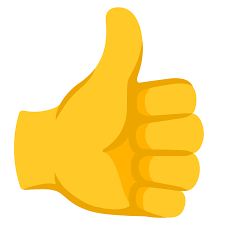

puedo hacer un modelo para encima de 6 y otro para debajo de 6 x ejemplo o montar categorias combinando las clases

### #3 Modelado para regresión

Reutiliza todo lo que puedas la preparación del modelado de la parte anterior y construye ahora el mejor modelo que puedas para predecir el grado alcohólico de un vino dadas sus características fisico químicas, su clase y la puntuación de calidad que le ha sido otorgada. Compara al menos tres tipos de modelos, seleccionando una métrica adecuada de comparación y escoge el más apropiado empleando validación cruzada antes o después de optimizar hiperparámetros (en la sesión en vivo lo haremos antes por cuestiones de tiempo). Evalúa el modelo escogido y con los hiperparámetros ajustados de la mejor manera que puedas. Para terminar realizar un pequeño análisis de errores.

In [112]:
train_reg, test_reg = train_test_split(df, test_size=.2, random_state=42)

In [119]:
corr = train_reg.corr(numeric_only= True)
np.abs(corr[target_reg]).sort_values(ascending = False)

alcohol                 1.000000
density                 0.682345
quality                 0.450403
residual sugar          0.357459
total sulfur dioxide    0.272970
chlorides               0.260508
free sulfur dioxide     0.188460
pH                      0.116497
fixed acidity           0.091964
volatile acidity        0.036041
citric acid             0.005690
sulphates               0.000412
Name: alcohol, dtype: float64

In [132]:
indices_corr = np.abs(corr[target_reg]).sort_values(ascending = False).index.to_list()

<Axes: >

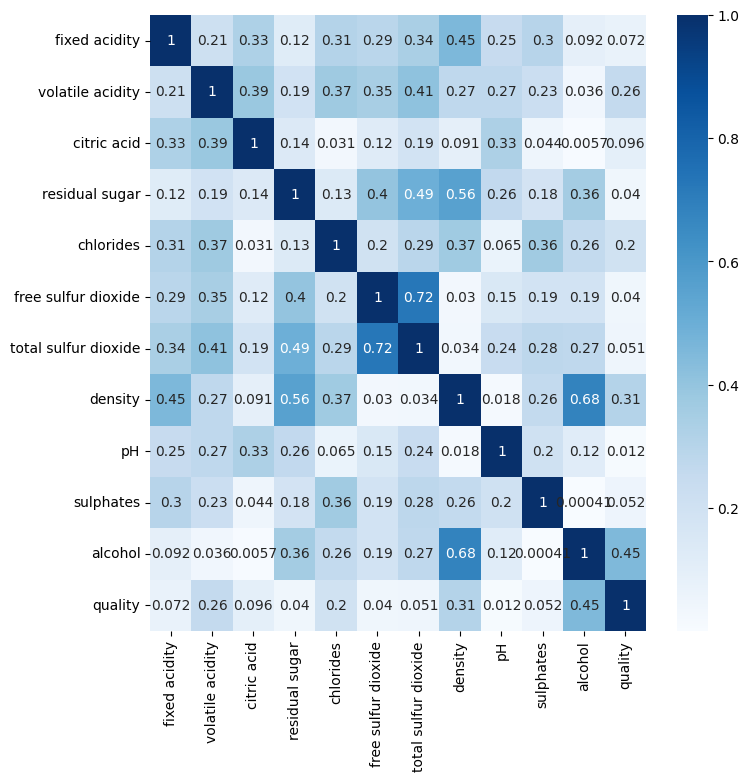

In [121]:
plt.figure(figsize = (8,8))
sns.heatmap(abs(corr), annot= True, cmap = "Blues")

In [133]:
features = indices_corr[:-4]

In [144]:
feat_num = train_reg.columns[:-3].to_list()
feat_num

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates']

In [145]:
feat_cat = train_reg.columns[-2:].to_list()
feat_cat

['quality', 'class']

In [146]:
scaler = StandardScaler()
train_reg[feat_num] = scaler.fit_transform(train_reg[feat_num])
test_reg[feat_num] = scaler.transform(test_reg[feat_num])

In [147]:
train_reg[feat_cat] = train_reg[feat_cat].replace({"white": 0, "red": 1})
test_reg[feat_cat] = test_reg[feat_cat].replace({"white": 0, "red": 1})

In [149]:
train_reg

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
1916,0.530566,-0.979287,0.553261,-0.682946,-0.206188,0.413075,-0.855503,0.426887,0.692811,2.696948,11.3,5,1
947,-0.087744,-0.979287,2.882601,2.118572,-0.359312,0.746349,1.063516,1.622065,1.005292,0.939171,9.0,6,0
877,0.298700,1.046217,-0.542899,-0.892015,-0.481811,-1.142201,-0.204093,-0.901088,-1.057086,-1.629887,10.8,6,0
2927,-0.937920,-0.549635,-0.268859,0.466930,-0.083689,0.357530,0.288866,0.058374,-0.994590,-0.210144,9.4,6,0
6063,1.380743,0.248291,0.621771,-0.641133,1.447549,-1.364383,-1.859027,0.440167,-0.557116,0.330710,11.9,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,-0.628765,-0.611014,1.238361,1.282298,-0.267438,1.635078,1.679715,0.626083,-0.244634,0.263103,9.3,5,0
5191,-0.474187,-0.733772,-0.268859,1.376378,0.069435,-0.309017,0.165626,1.276791,1.442767,-0.548178,9.4,5,0
5226,-0.474187,-0.856530,0.416241,0.508744,-0.114314,-0.031289,0.517740,-0.004705,0.630314,0.195496,11.0,7,0
5390,0.066834,0.432428,-0.200349,-0.766574,-0.726809,-0.253471,-0.732264,-1.933589,-1.619553,-1.224246,13.0,8,0


In [151]:
X_train = train_reg[features]
y_train = train_reg[target_reg]

X_test = test_reg[features]
y_test = test_reg[target_reg]

#### modelos

In [171]:
rf = RandomForestRegressor()
lgbm = LGBMRegressor(verbose=-1)

regresores = rf, lgbm

In [173]:
for modelo in regresores:
    print(modelo, round(-(cross_val_score(modelo, X_train, y_train, cv=5, scoring="neg_mean_absolute_percentage_error")).mean(), 4))

RandomForestRegressor() 0.0001
LGBMRegressor(verbose=-1) 0.0003


In [174]:
param_grid = {
    "n_estimators": [100,200,400], # 
    "max_depth": [1,5,10],
    "min_samples_leaf": [1,10,20],
    "max_features": ["sqrt","log2",None]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="neg_mean_absolute_error")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 5, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 10, 20],
                         'n_estimators': [100, 200, 400]},
             scoring='neg_mean_absolute_error')

In [176]:
train_pred = grid_search.best_estimator_.predict(X_train)

print("MAE:", mean_absolute_error(y_train, train_pred))
print("MAPE:", mean_absolute_percentage_error(y_train, train_pred))

MAE: 0.00017048938492409123
MAPE: 1.6980362842871383e-05


In [177]:
test_pred = grid_search.best_estimator_.predict(X_test)

print("MAE:", mean_absolute_error(y_test, test_pred))
print("MAPE:", mean_absolute_percentage_error(y_test, test_pred))

MAE: 0.001337371794894637
MAPE: 0.00011169300451578586


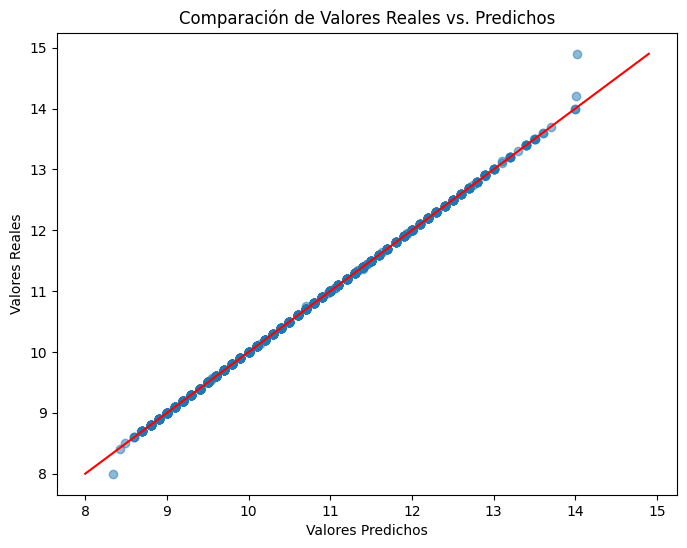

In [179]:

def plot_predictions_vs_actual(y_real, y_pred):
    """
    Función para graficar los valores reales vs. los valores predichos en una regresión.

    Args:
    y_real (array-like): Valores reales de la variable objetivo.
    y_pred (array-like): Valores predichos de la variable objetivo.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_real, alpha=0.5)
    plt.xlabel("Valores Predichos")
    plt.ylabel("Valores Reales")

    # Línea y=x
    max_value = max(max(y_real), max(y_pred))
    min_value = min(min(y_real), min(y_pred))
    plt.plot([min_value, max_value], [min_value, max_value], 'r')

    plt.title("Comparación de Valores Reales vs. Predichos")
    plt.show()

plot_predictions_vs_actual(y_test, test_pred)

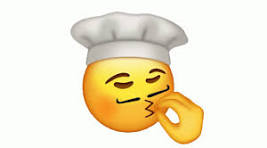